0. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import chi2

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.filters.hp_filter import hpfilter

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 

import warnings


0. Data Prepocessing

- CPI: OECD (2024), Inflation (CPI) (indicator). doi: 10.1787/eee82e6e-en (Accessed on 10 June 2024)
- LTR: OECD (2024), Long-term interest rates (indicator). doi: 10.1787/662d712c-en (Accessed on 10 June 2024)
- STR: OECD (2024), Short-term interest rates (indicator). doi: 10.1787/2cc37d77-en (Accessed on 10 June 2024)
- GDP: OECD (2024), Quarterly GDP (indicator). doi: 10.1787/b86d1fc8-en (Accessed on 17 June 2024)
- IPI: Eurostat (2024) https://ec.europa.eu/eurostat/web/short-term-business-statistics/database. Code:sts_inpr_m (Accessed on 10 June 2024)

Below is the code used to read the raw data from the internet and save it into the data.xlsx file

In [2]:
# # IPI
# df_ltu_ipi = pd.read_csv('LTU_IPI.tsv.gz', delimiter='\t', compression='gzip')
# ipi_series = df_ltu_ipi.iloc[2]  # row 2 reprenents M,PROD,B-D,NSA,I21,LT: Index 2021=100, unadjasted data Mining and quarrying; manufacturing; electricity, gas, steam and air conditioning supply
# ipi_series = ipi_series.drop(df_ltu_ipi.columns[0])
# ipi_series.index = pd.to_datetime(ipi_series.index).to_period('Q').to_timestamp('Q')
# ipi_series = ipi_series[ipi_series != ':']
# ipi_series = pd.to_numeric(ipi_series, errors='coerce')
# ipi_series = ipi_series.dropna()
# ipi = ipi_series.to_frame(name='ipi')
# ipi_quarterly = ipi.resample('Q').mean()


# # CPI
# df_ltu_cpi = pd.read_csv('LTU_CPI.csv')
# cpi = df_ltu_cpi[['TIME_PERIOD', 'OBS_VALUE']]
# cpi.rename(columns={'OBS_VALUE': 'cpi'}, inplace=True)
# cpi.set_index('TIME_PERIOD', inplace=True)
# cpi.index = pd.to_datetime(cpi.index).to_period('Q').to_timestamp('Q')
# cpi_quarterly = cpi.resample('Q').mean()

# df_ltu_ir = pd.read_csv('LTU_IR.csv')

# # LTR
# ltr = df_ltu_ir[df_ltu_ir['MEASURE'] == 'IRLT']
# ltr = ltr[['TIME_PERIOD', 'OBS_VALUE']]
# ltr.rename(columns={'OBS_VALUE': 'ltr'}, inplace=True)
# ltr.set_index('TIME_PERIOD', inplace=True)
# ltr.index = pd.to_datetime(ltr.index).to_period('Q').to_timestamp('Q')
# ltr_quarterly = ltr.resample('Q').mean()

# # STR 
# sr = df_ltu_ir[df_ltu_ir['MEASURE'] == 'IR3TIB']
# sr = sr[['TIME_PERIOD', 'OBS_VALUE']]
# sr.rename(columns={'OBS_VALUE': 'str'}, inplace=True)
# sr.set_index('TIME_PERIOD', inplace=True)
# sr.index = pd.to_datetime(sr.index).to_period('Q').to_timestamp('Q')
# sr_quarterly = sr.resample('Q').mean()

# # GDP 
# df_ltu_gdp = pd.read_csv('LTU_GDP.csv')
# gdp_quarterly = df_ltu_gdp[['TIME_PERIOD', 'OBS_VALUE']]
# gdp_quarterly.rename(columns={'OBS_VALUE': 'gdp'}, inplace=True)
# gdp_quarterly.set_index('TIME_PERIOD', inplace=True)
# gdp_quarterly.index = pd.to_datetime(gdp_quarterly.index).to_period('Q').to_timestamp('Q')

# data = pd.concat([ipi_quarterly, cpi_quarterly, ltr_quarterly, sr_quarterly, gdp_quarterly], axis=1)
# data = data.dropna()

# with pd.ExcelWriter('data.xlsx', engine='openpyxl') as writer:
#     data.to_excel(writer, sheet_name='data', index=True)


In [3]:
data = pd.read_excel('data.xlsx', index_col=0)

2. Compute derived quantities

The necessary quantities were computed according to formulae in the project description 

In [4]:
cpi_base = data['cpi'].iloc[0]                                                          # Base year for CPI
data['pi_t'] = (data['cpi'].pct_change(periods=1) * 4)                                  # Inflation rate                            
data['real_SR'] = ((1 + data['str']) / (1 + data['pi_t'])) - 1                          # Real short rate  
data['TS'] = data['ltr'] - data['str']                                                  # Term spread         
data['real_gdp'] = data['gdp'] / (data['cpi'] / cpi_base)                               # Real GDP
data['st_growth'] = 400 * np.log(data['real_gdp'].shift(-1) / data['real_gdp'])         # Short term growth
data['lt_growth'] = 400 / 4 * np.log(data['real_gdp'].shift(-4) / data['real_gdp'])     # Long term growth   

# some extra variables:
data['real_LTR'] = ((1 + data['ltr']) / (1 + data['pi_t'])) - 1 
data['Real_TS'] = data['real_LTR'] - data['real_SR']
data['real_gdp_growth'] = data['real_gdp'].pct_change(periods=1)
data['real_gdp_cycle'], data['real_gdp_trend'] = hpfilter(data['real_gdp'], lamb=1600)
data['output_gap'] = data['real_gdp'] - data['real_gdp_trend']

data = data.dropna()   

3. Exploratory data analysis

In [5]:
data

,ipi,cpi,ltr,str,gdp,pi_t,real_SR,TS,real_gdp,st_growth,lt_growth,real_LTR,Real_TS,real_gdp_growth,real_gdp_cycle,real_gdp_trend,output_gap
2001-06-30,38.166667,70.165033,8.474000,6.357215,1.410647e+10,0.047407,6.024220,2.116785,1.394124e+10,0.017415,6.836496,8.045197,2.020977,-0.007438,4.177104e+08,1.352353e+10,4.177104e+08
2001-09-30,38.166667,70.238000,8.154333,5.413205,1.412175e+10,0.004160,5.386638,2.741128,1.394185e+10,6.882979,9.275739,8.116412,2.729773,0.000044,1.261296e+07,1.392923e+10,1.261296e+07
2001-12-31,44.033333,70.566900,6.744000,4.647125,1.443413e+10,0.018731,4.543295,2.096875,1.418383e+10,2.918906,8.393291,6.601617,2.058322,0.017356,-1.525322e+08,1.433636e+10,-1.525322e+08
2002-03-31,40.033333,71.128533,6.274333,4.557985,1.465556e+10,0.031836,4.386503,1.716349,1.428771e+10,17.526683,12.725387,6.049896,1.663394,0.007324,-4.580438e+08,1.474575e+10,-4.580438e+08
2002-06-30,41.600000,70.485833,6.132667,3.462144,1.517364e+10,-0.036143,3.629467,2.670522,1.492767e+10,9.774386,8.425984,6.400130,2.770662,0.044791,-2.305007e+08,1.515817e+10,-2.305007e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,114.333333,128.222333,0.160000,-0.529026,6.408308e+10,0.215396,-0.612493,0.689026,3.465641e+10,-8.902659,-6.737174,-0.045579,0.566915,0.011933,1.759192e+09,3.289722e+10,1.759192e+09
2022-06-30,104.900000,136.609533,0.160000,-0.357616,6.677205e+10,0.261646,-0.490837,0.517616,3.389359e+10,-3.254054,-3.638611,-0.080566,0.410271,-0.022011,8.510891e+08,3.304250e+10,8.510891e+08
2022-09-30,109.066667,143.812733,0.160000,0.480741,6.972331e+10,0.210914,0.222829,-0.320741,3.361898e+10,-18.223853,-1.600148,-0.042046,-0.264875,-0.008102,4.436318e+08,3.317535e+10,4.436318e+08
2022-12-31,107.966667,149.316900,1.973333,1.772123,6.916770e+10,0.153093,1.404077,0.201210,3.212168e+10,3.431870,2.744397,1.578573,0.174496,-0.044537,-1.176894e+09,3.329858e+10,-1.176894e+09


Summary statistics:

In [6]:
summary_stats = data[['cpi', 'ltr', 'str', 'gdp']].describe()
summary_stats

,cpi,ltr,str,gdp
count,88.000000,88.000000,88.000000,8.800000e+01
mean,94.903641,3.671352,1.875061,3.469150e+10
std,18.949942,3.225633,2.327416,1.403695e+10
min,68.990733,0.160000,-0.566377,1.410647e+10
25%,75.909342,0.310000,-0.302637,2.538522e+10
50%,98.821550,3.859333,1.483030,3.316023e+10
75%,105.178742,5.150000,2.999344,4.295819e+10
max,151.858500,14.500000,8.021772,7.095118e+10


Let us plot the variables and see what we are working with:

In [7]:
# Iterate over each column in the DataFrame
def plot_graphs(data):
    for column in data.columns:
        fig = plt.figure()
        fig.suptitle(column)
        plt.plot(data.index, data[column])
        plt.xlabel('Time')
        plt.ylabel(column)
        plt.grid(True)
        plt.show()

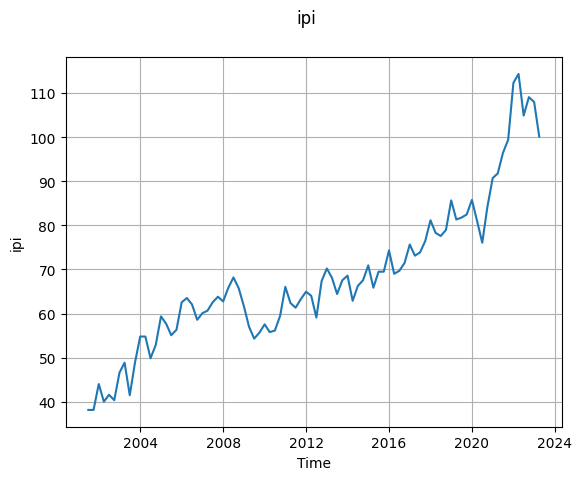

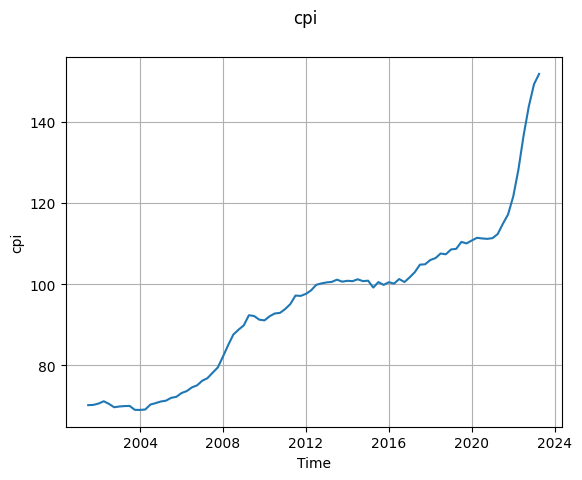

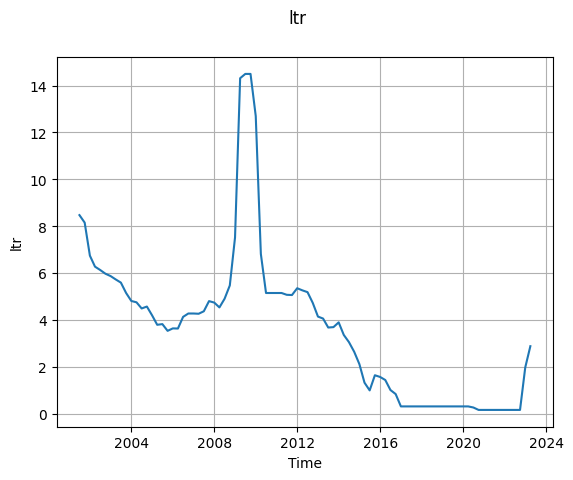

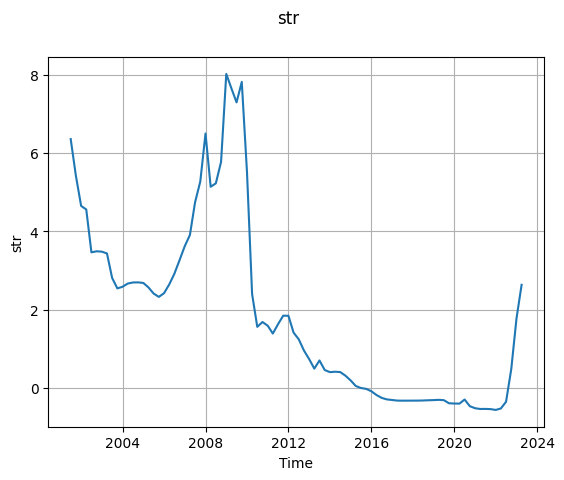

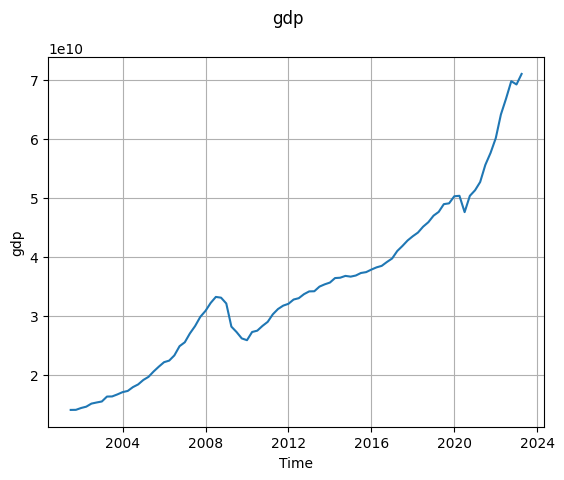

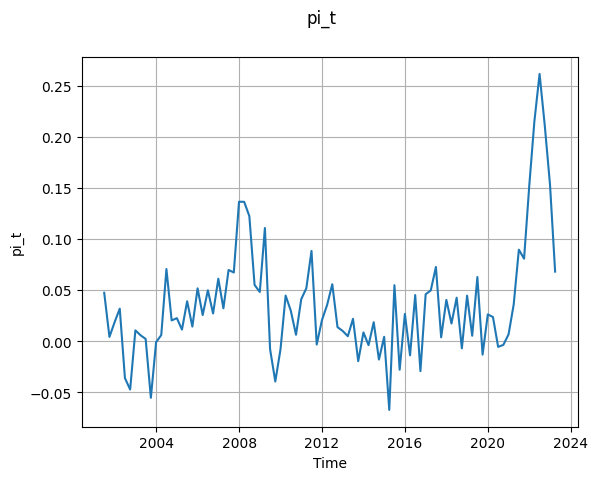

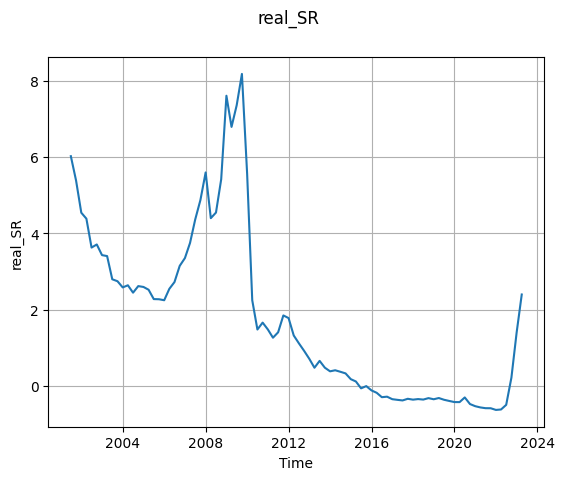

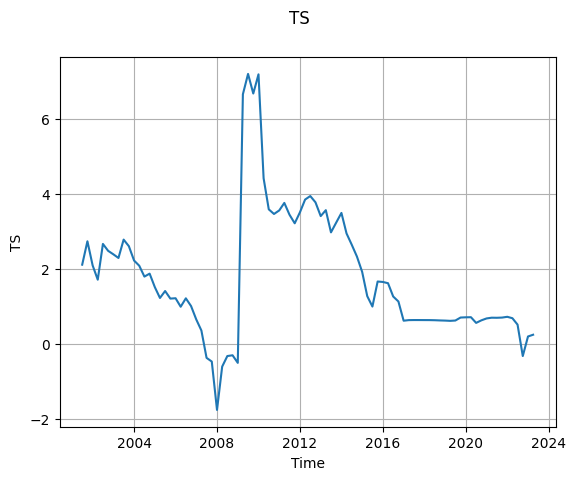

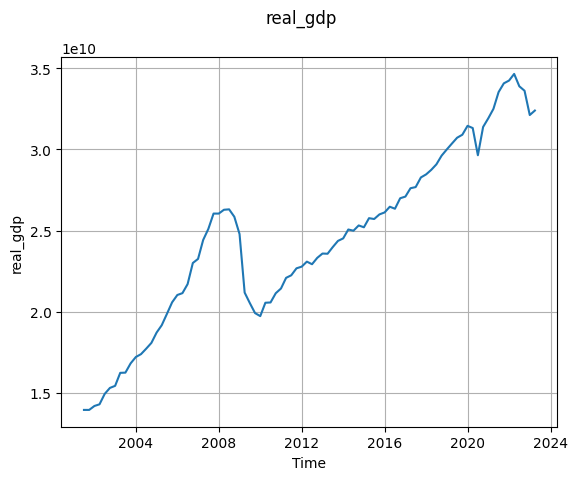

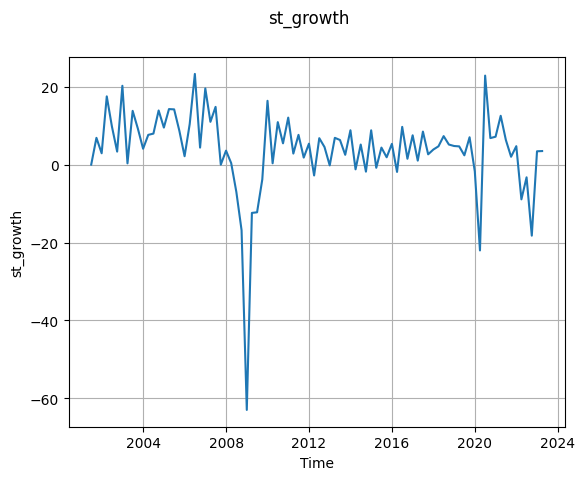

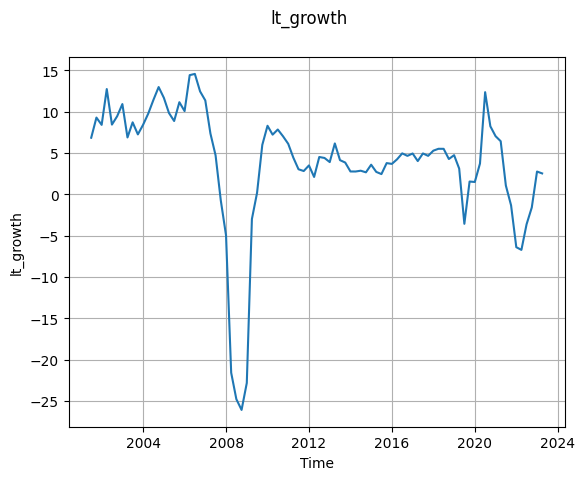

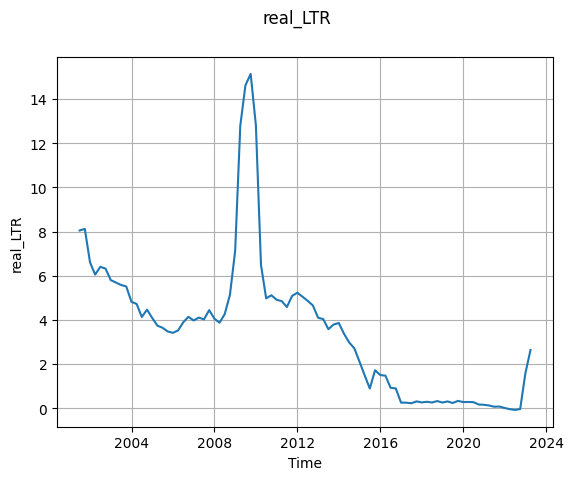

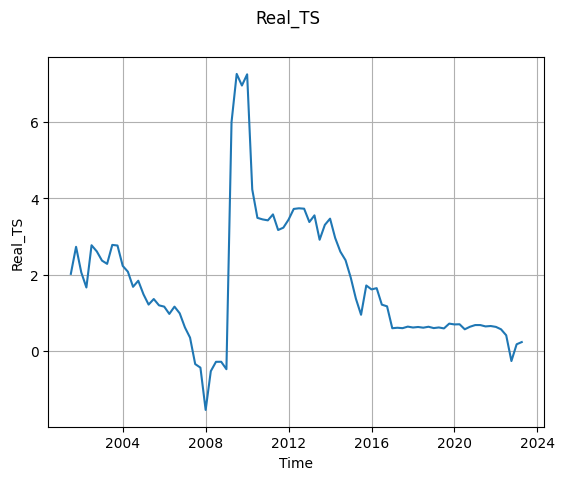

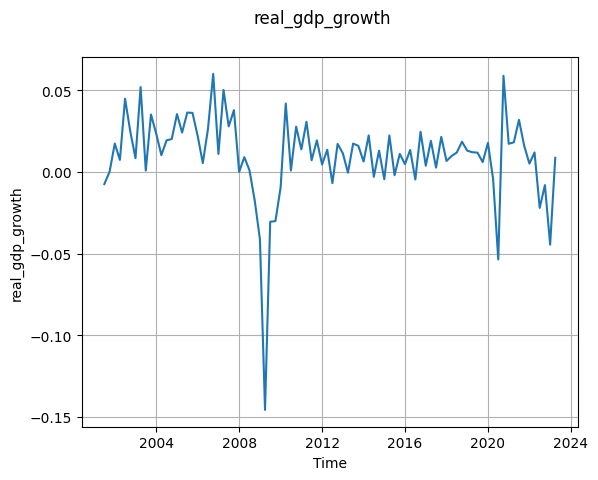

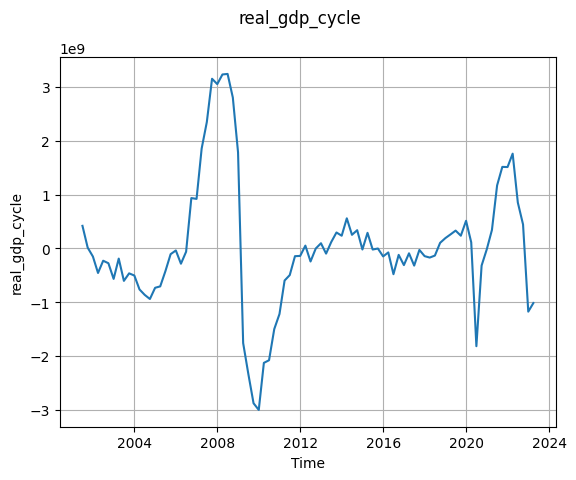

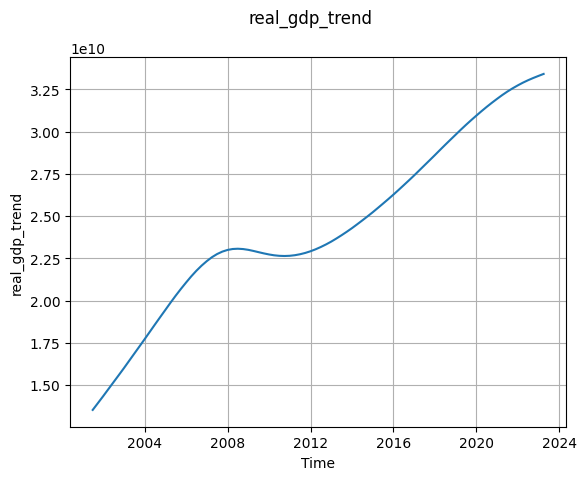

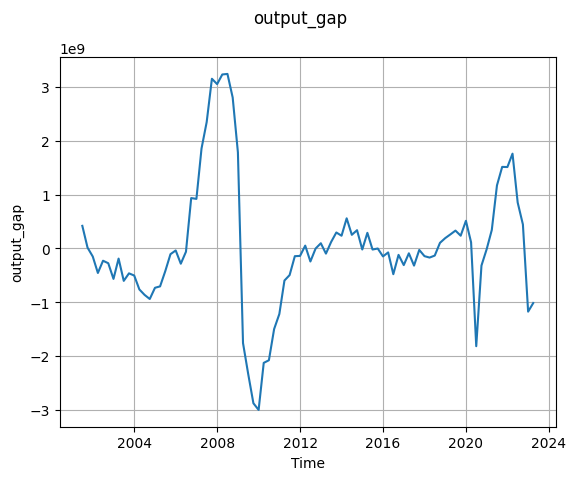

In [8]:
plot_graphs(data)

4. Stationarity analysis

Functions to efficiently perform ACF_PACF tests for stationarity have been coded. 

In [9]:
def ACF_PACF(y):
    print('------------------------------- (2) ACF and PACF plot -------------------------------')
    plot_acf(y)
    plt.show()
    plot_pacf(y,method='ywm')
    plt.show()

In [10]:
def stationarity_analysis(y, verbose=False):   
    res_c = tsa.adfuller(y, regression='c', autolag='AIC')
    res_ct = tsa.adfuller(y, regression='ct', autolag='AIC')
    res_ctt = tsa.adfuller(y, regression='ctt', autolag='AIC')
    res_n= tsa.adfuller(y, regression='n', autolag='AIC')

    if verbose:
        print("====================================================================================================")

        print('\n------------------------------- (1) Time series plot -------------------------------')
        plt.plot(y)
        plt.title('Title here')
        plt.ylabel('Variable')
        plt.xlabel('Date')
        plt.show()
        
        # ACF and PACF test plots
        ACF_PACF(y)

        print('------------------------------- (3) ADF test -------------------------------')
        print("ADF test - various underlying models:")
        print("    (1) ADF p-value (const):", res_c[1])
        print("    (2) ADF p-value (const + trend):", res_ct[1])
        print("    (3) ADF p-value (const + trend + quad trend):", res_ctt[1])
        print("    (4) ADF p-value (no const + no trend):", res_n[1])
        print("====================================================================================================")

    return res_c[1], res_ct[1], res_ctt[1], res_n[1]


Now, let's iteratively call `stationarity_analysis` function for various transformations of each variable of interest, to choose a relevant transformation for each variable of interest, to ensure stationarity. For that purpose we define a function `get_stationarity_analysis_results` which returns a table with ADF test results for a number of tyypical variable transformations:

In [11]:
def get_stationarity_analysis_results(variable):
    """Compute ADF test for variable and it's popular transformations. Returns dataframe with p-values for each transformation."""
    log = np.log(variable)
    first_diff = variable.diff().dropna()
    log_first_diff = np.log(variable).diff().dropna()
    second_diff = variable.diff().dropna().diff().dropna()

    model_results = pd.DataFrame(columns=['p_c', 'p_ct', 'p_ctt', 'p_n'])

    for name, var in [('y', variable), ('ly', log), ('dy', first_diff), ('dly', log_first_diff), ('d2y', second_diff)]:
        var = var.dropna()
        res_c, res_ct, res_ctt, res_n = stationarity_analysis(var)
        model_results.loc[name] = { 'p_c': res_c, 'p_ct': res_ct, 'p_ctt': res_ctt, 'p_n': res_n}

    return model_results

In [12]:
get_stationarity_analysis_results(data['lt_growth'])

c:\Users\mikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,p_c,p_ct,p_ctt,p_n
y,2.447391e-01,5.434672e-01,8.514149e-01,5.592782e-02
ly,9.202352e-05,9.266136e-06,1.293439e-03,2.651578e-01
dy,1.130116e-03,7.887407e-03,2.421474e-02,2.306862e-03
dly,1.403899e-13,5.915375e-12,2.003790e-11,2.068531e-14
d2y,1.494271e-04,1.349720e-03,6.078381e-03,6.171032e-06


In [13]:
get_stationarity_analysis_results(data['st_growth'])

c:\Users\mikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,p_c,p_ct,p_ctt,p_n
y,1.897531e-03,8.692700e-03,2.695004e-02,3.887449e-04
ly,5.128798e-08,2.797656e-07,1.041725e-19,2.582341e-01
dy,2.358728e-29,0.000000e+00,1.074771e-24,3.289072e-28
dly,3.849722e-09,1.104034e-07,8.570094e-07,4.278488e-10
d2y,8.603521e-06,1.045662e-04,6.559320e-04,3.389160e-07


In [14]:
get_stationarity_analysis_results(data['real_SR'])

c:\Users\mikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,p_c,p_ct,p_ctt,p_n
y,4.574909e-01,8.358433e-01,9.670009e-01,1.114374e-01
ly,9.939082e-01,9.942789e-01,7.349153e-01,5.822218e-01
dy,6.473496e-05,4.311026e-04,1.488825e-03,2.808626e-06
dly,2.158088e-01,6.809276e-01,9.890648e-01,2.910158e-02
d2y,1.293535e-08,2.485404e-07,9.788917e-07,7.975563e-10


In [15]:
get_stationarity_analysis_results(data['TS'])

c:\Users\mikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,p_c,p_ct,p_ctt,p_n
y,1.278768e-01,2.702584e-01,3.806691e-01,6.454842e-02
ly,4.521299e-01,2.505806e-01,1.437441e-01,7.404086e-02
dy,7.558617e-15,5.449670e-13,2.443390e-12,1.553249e-15
dly,4.035510e-14,5.836302e-06,3.608865e-06,3.207393e-13
d2y,4.620108e-08,8.214002e-07,6.008304e-06,2.268376e-09


In [16]:
# extra chosen variable - real GDP
get_stationarity_analysis_results(data['real_gdp'])

,p_c,p_ct,p_ctt,p_n
y,4.837173e-01,1.314440e-01,2.813443e-01,9.227578e-01
ly,2.480978e-01,1.039954e-01,2.780666e-01,9.612745e-01
dy,1.444580e-03,8.522391e-03,3.286870e-02,2.339863e-04
dly,3.152363e-03,1.252187e-02,4.042555e-02,5.393989e-04
d2y,7.328556e-16,6.771281e-14,2.639188e-13,1.865834e-16


Having investigated all the possibilities, the following transformed variables were chosen for the modellng:

In [17]:
# chosen transformations for model all stationary due to ADF test for all regression types for 5% confidence interval:
ts = data['TS'].diff().dropna()
rSR = data['real_SR'].diff().dropna()
rGDP = data['real_gdp'].diff().dropna()
stg = data['st_growth'] 
ltg = data['lt_growth'].diff().dropna()


transformed_data = pd.concat([ts, rSR, rGDP, stg, ltg], axis=1).dropna()
transformed_data.rename(columns={'TS': 'd_TS', 'real_SR': 'd_real_SR', 'real_gdp': 'd_real_GDP', 'st_growth': 'st_g', 'lt_growth': 'd_lt_g'}, inplace=True)

In [18]:
transformed_data.describe()

,d_TS,d_real_SR,d_real_GDP,st_g,d_lt_g
count,87.000000,87.000000,8.700000e+01,87.000000,87.000000
mean,-0.021479,-0.041653,2.121520e+08,3.916989,-0.049628
std,0.911163,0.636000,6.534769e+08,10.811438,3.776400
min,-2.771625,-3.309418,-3.609214e+09,-62.954291,-16.636493
25%,-0.291903,-0.167603,4.860230e+07,1.269150,-1.304187
50%,-0.011974,-0.026036,3.088312e+08,4.745078,-0.212919
75%,0.073178,0.122084,5.435812e+08,8.750791,1.343133
max,7.165042,2.188552,1.743328e+09,23.289813,19.835918


The plots of the transformed variables can be seen below:

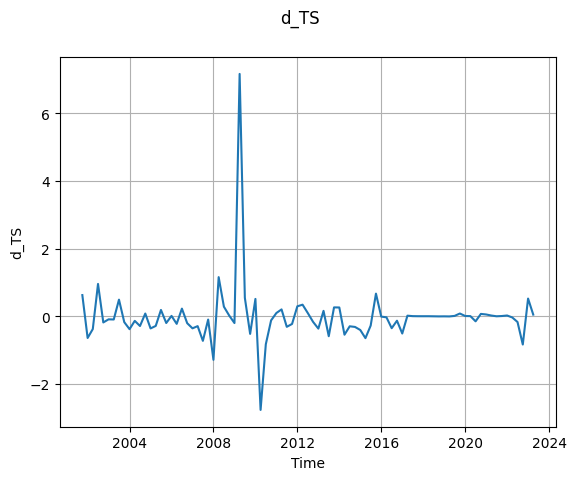

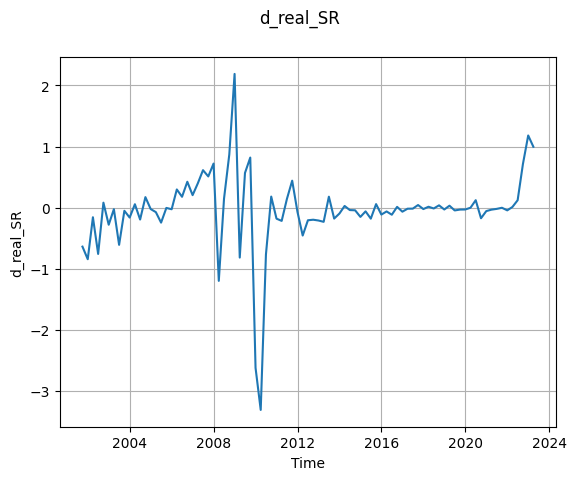

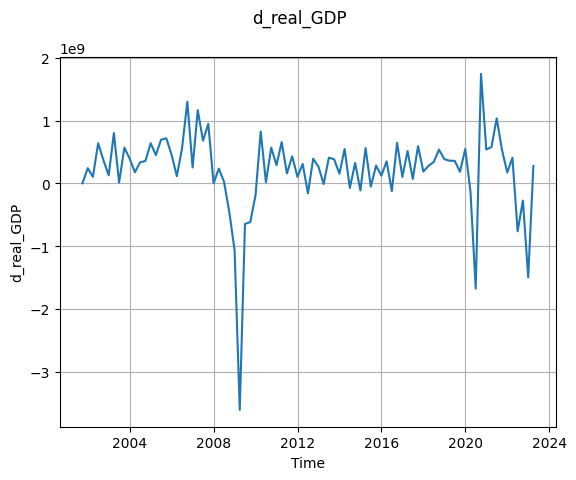

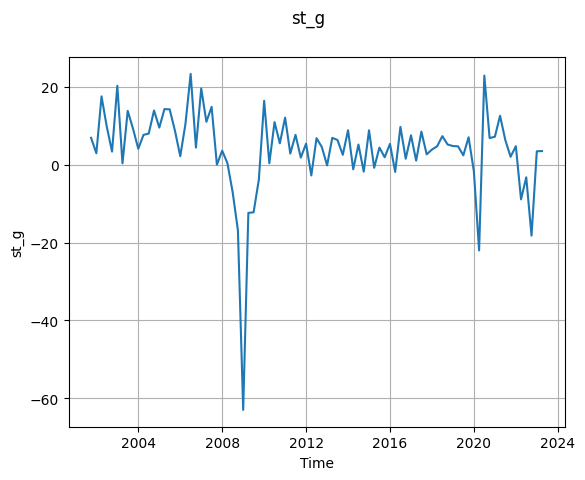

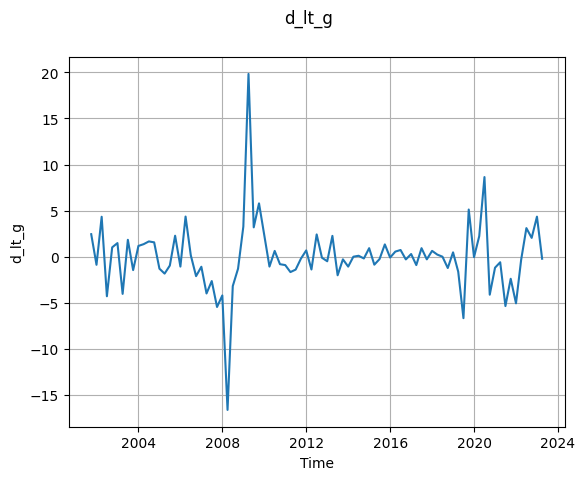

In [19]:
plot_graphs(transformed_data)

Now let's look at the ACF / PACF plots to spot autocorrelation

------------------------------- (2) ACF and PACF plot -------------------------------


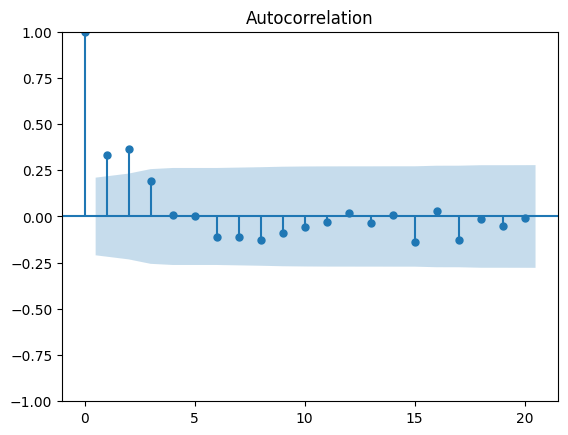

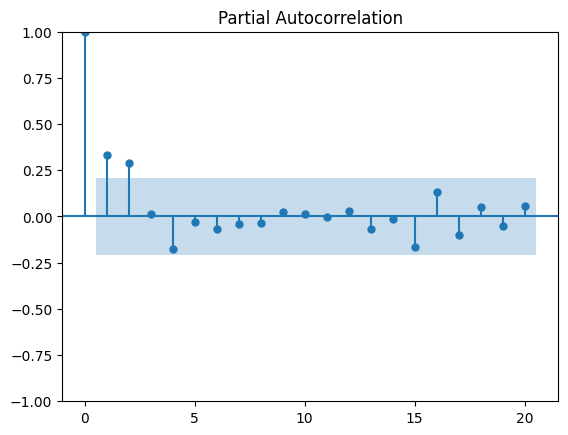

In [20]:
ACF_PACF(transformed_data['st_g'])

based on ADF PACF test, 3 lags of st_g used

------------------------------- (2) ACF and PACF plot -------------------------------


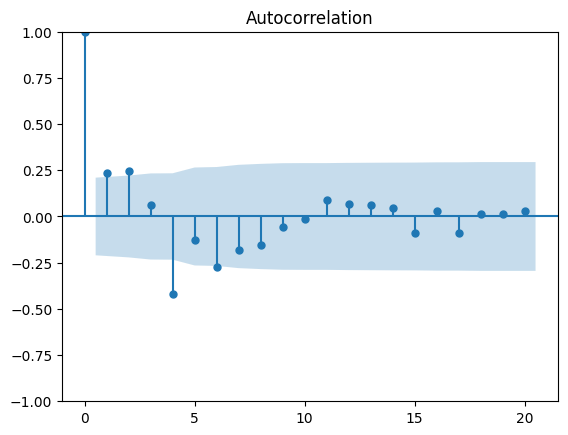

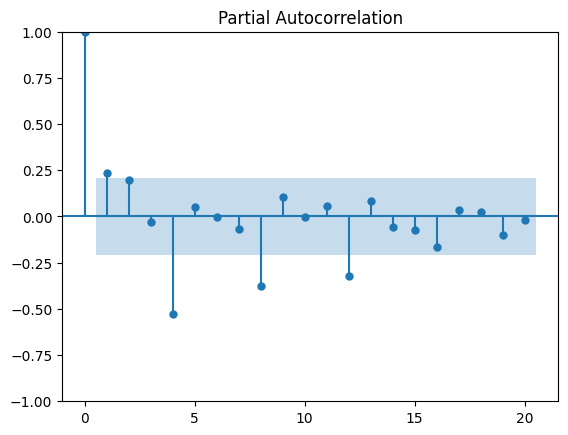

In [21]:
ACF_PACF(transformed_data['d_lt_g'])

Based on ACF for d_lt_g, only 1 lag will be used in the model

5. Baseline Models


In [22]:
# add lagged variables to the dataset
transformed_data['st_g.shift(1)'] = transformed_data['st_g'].shift(1)
transformed_data['st_g.shift(2)'] = transformed_data['st_g'].shift(2)
transformed_data['st_g.shift(3)'] = transformed_data['st_g'].shift(3)
transformed_data['d_lt_g.shift(1)'] = transformed_data['d_lt_g'].shift(1)
transformed_data = transformed_data.dropna()

In [23]:
#Baseline model 1
formula_st = 'st_g ~ st_g.shift(1) + st_g.shift(2) + st_g.shift(3) + d_TS + d_real_SR + d_real_GDP'
baseline_model_st = smf.ols(formula=formula_st, data=transformed_data)
st_results = baseline_model_st.fit(cov_type='HAC',cov_kwds={'maxlags':12})

#Baseline model 2
formula_lt = 'd_lt_g ~ d_lt_g.shift(1) + d_TS + d_real_SR + d_real_GDP'
baseline_model_lt = smf.ols(formula=formula_lt, data=transformed_data) 
lt_results = baseline_model_lt.fit(cov_type='HAC',cov_kwds={'maxlags':12})

Model regression results:

In [24]:
print(st_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   st_g   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     8.801
Date:                Sat, 22 Jun 2024   Prob (F-statistic):           1.37e-06
Time:                        12:50:17   Log-Likelihood:                -293.16
No. Observations:                  81   AIC:                             600.3
Df Residuals:                      74   BIC:                             617.1
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2606      1.220      1.033

c:\Users\mikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '


In [25]:
print(lt_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 d_lt_g   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     5.517
Date:                Sat, 22 Jun 2024   Prob (F-statistic):            0.00173
Time:                        12:50:17   Log-Likelihood:                -194.97
No. Observations:                  83   AIC:                             399.9
Df Residuals:                      78   BIC:                             412.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7542      0.302     

c:\Users\mikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '


6. Nested Models

Now, let's define 3 nested models, which are simplified baseline modesl. Two models are defiend for short-term growth and one model is defined for long-term growth.

In [26]:
# Short-term growth + only TS
formula_s_TS = 'st_g ~ st_g.shift(1) + st_g.shift(2) + st_g.shift(3) + d_TS'
model_s_TS = smf.ols(formula=formula_s_TS, data=transformed_data)
s_TS_results = model_s_TS.fit(cov_type='HAC',cov_kwds={'maxlags':12})

# Short-term growth + only real GDP
formula_s_rGDP = 'st_g ~ st_g.shift(1) + st_g.shift(2) + st_g.shift(3) + d_real_GDP'
model_s_rGDP = smf.ols(formula=formula_s_rGDP, data=transformed_data)
s_rGDP_results = model_s_rGDP.fit(cov_type='HAC',cov_kwds={'maxlags':12})

# Short-term growth + only real SR
formula_s_rSR = 'st_g ~ st_g.shift(1) + st_g.shift(2) + st_g.shift(3) + d_real_SR'
model_s_rSR = smf.ols(formula=formula_s_rSR, data=transformed_data)
s_rSR_results = model_s_rSR.fit(cov_type='HAC',cov_kwds={'maxlags':12})

# Long-term growth + only TS
formula_l_TS = 'd_lt_g ~ d_lt_g.shift(1) + d_TS'
model_l_TS = smf.ols(formula=formula_l_TS, data=transformed_data)
l_TS_results = model_l_TS.fit(cov_type='HAC',cov_kwds={'maxlags':12})

# Long-term growth + only real GDP
formula_l_rGDP = 'd_lt_g ~ d_lt_g.shift(1) + d_real_GDP'
model_l_rGDP = smf.ols(formula=formula_l_rGDP, data=transformed_data)
l_rGDP_results = model_l_rGDP.fit(cov_type='HAC',cov_kwds={'maxlags':12})

# Long-term growth + only real SR
formula_l_rSR = 'd_lt_g ~ d_lt_g.shift(1) + d_real_SR'
model_l_rSR = smf.ols(formula=formula_l_rSR, data=transformed_data) 
l_rSR_results = model_l_rSR.fit(cov_type='HAC',cov_kwds={'maxlags':12})

7. Autoregressive Model

Let's ulso fit a AR model for the optimal number of lags found earlier:


In [27]:
model_st = ARIMA(transformed_data['st_g'], order=(3, 0, 0))
ar_st_results = model_st.fit()

model_lt = ARIMA(transformed_data['d_lt_g'], order=(1, 0, 0))
ar_lt_results = model_lt.fit()

In [28]:
def analyze_AR_model(model_results, verbose=False):
    """Analyze model results: heteroscedasticity, autocorrelation, normality tests. Returns results."""

    # Heteroscedasticity: Goldfeld-Quandt test
    GQres = model_results.test_heteroskedasticity('breakvar')
    GQres = GQres[0]

    if verbose:
        print('\n (1) Testing heteroscedasticity: Goldfeld-Quandt test')
        print('     H0: no heteroscedasticity')
        print('     H1: heteroscedasticity')
        print("\n     Goldfeld-Quandt test stat:",GQres[0])
        print("                       p-value:",GQres[1])
        print('----------------------------------------------------------------------------------------------\n')

    # (1) Autocorrelation: Ljung-Box Q test and Box-Pierce Q test
    lagnum = 12
    # (1.1) Ljung-Box Q test
    LBres = model_results.test_serial_correlation('ljungbox',lags=lagnum)
    LBres = LBres[0]
    # (1.2) Box-Pierce Q test
    BPres = model_results.test_serial_correlation('boxpierce',lags=lagnum)
    BPres = BPres[0]

    LB_BP_Qstat = pd.DataFrame({'lag':list(range(1,lagnum+1)),
                                'Ljung-Box Q stat':LBres[0],
                                'LB p-value':LBres[1],
                                'Box-Pierce Q stat':BPres[0],
                                'BP p-value':BPres[1]})

    if verbose:
        LB_BP_Qstat

        print('(2) Testing autocorrelation: Ljung-Box Q test and Box-Pierce Q test')
        print('      H0: no serial correlation up to a given lag')
        print(LB_BP_Qstat)
        print('----------------------------------------------------------------------------------------------\n')

    lagnum = 24
    eps = model_results.resid
    acf,q,pval = tsa.acf(eps,nlags=lagnum,qstat=True)
    pacf = tsa.pacf(eps,nlags=lagnum)
    acf_pacf = pd.DataFrame({'lag':list(range(1,lagnum+1)),
                            'ACF':acf[1:],
                            'PACF':pacf[1:]})

    LB_BP_test = statsmodels.stats.diagnostic.acorr_ljungbox(eps, lags=lagnum, boxpierce=True, 
                                                model_df=0, period=None, return_df=True, auto_lag=False)
    LB_BP_test.columns = ['LB Q stat', 'LB p-value','BP Q stat', 'BP p-value']
    LB_BP_test.index = range(len(LB_BP_test))

    correlogram = pd.concat([acf_pacf, LB_BP_test], axis=1)

    if verbose:
        print(LB_BP_test)

        print(" ------------------  Correlogram with LB and BP tests ------------------")
        print(correlogram)
        print("------------------------------------------------------------------------")


        print('\n ------------------------------- ACF and PACF plot -------------------------------')
        plot_acf(eps)
        plt.show()
        plot_pacf(eps,method='ywm')
        plt.show()

    JBres = model_results.test_normality('jarquebera')
    JBres = JBres[0]

    if verbose:
        print('\n (3) Testing normality: Jarque Bera test')
        print('      H0: normal dostribution')
        print("        Jarque Bera test stat:",JBres[0])
        print("                      p-value:",JBres[1])
        print('----------------------------------------------------------------------------------------------\n')

    return GQres[0], GQres[1], LB_BP_Qstat, correlogram, JBres[0], JBres[1]

8. Naive Forecast

In [29]:
def naive_forecast(series):
    predictions = series.shift(1).dropna()  # Naive forecast: Y_{t+1} = Y_t
    return predictions

naive_forecast_st = naive_forecast(transformed_data['st_g'])
naive_forecast_lt = naive_forecast(transformed_data['d_lt_g'])

9. Moving Average forecasts for 8 quarters

In [30]:
def moving_average_forecast(series, window):
    predictions = series.rolling(window=window).mean().dropna()
    return predictions

ma8_st_forecast = moving_average_forecast(transformed_data['st_g'], 8)
ma8_lt_forecast = moving_average_forecast(transformed_data['d_lt_g'], 8)

10. Model Comparison

using forecast metrics, the models will be compared and contrasted

In [31]:
def compute_evaluation_statistics(y, y_pred):
    MSE = np.mean( (y - y_pred) ** 2 ) 
    RMSE = np.sqrt(MSE)
    MAE = np.mean( np.abs(y - y_pred) )
    MAPE =  np.mean( np.abs( (y - y_pred) / y ) )
    
    return (MSE, RMSE, MAE, MAPE)

In [32]:
st_models = [st_results, ar_st_results, s_TS_results, s_rGDP_results, s_rSR_results]
lt_models = [lt_results, ar_lt_results, l_TS_results, l_rGDP_results, l_rSR_results]

IS prediction for ARMA models

In [33]:
def get_IS_pred(model_results):
    pred_results = model_results.get_prediction()
    fcast_full = pred_results.summary_frame()
    y_forec = fcast_full['mean']
    return y_forec

Short-term Baseline: (81.4942060053045, 9.02741413724354, 6.073350754510649, 18.549270570629975)
AR(3): (95.54854560838142, 9.774893636678684, 5.965947774377777, 26.257732975782385)
Nested only TS: (93.17329082922227, 9.652631290442118, 6.029796471258616, 28.734814867083173)
Nested only real GDP: (95.49252258530893, 9.772027557539374, 5.94854378735987, 25.269149158293096)
Nested only real SR: (83.62947363170996, 9.144915179033099, 5.8745546092808905, 18.63340096356318)
Naive forecast: (158.26813141581945, 12.580466263848072, 8.682880136236365, 47.859151832344736)
Eight Quarter Moving Average: (106.49505699238298, 10.319644227994635, 6.212160809316163, 36.6988011053165)


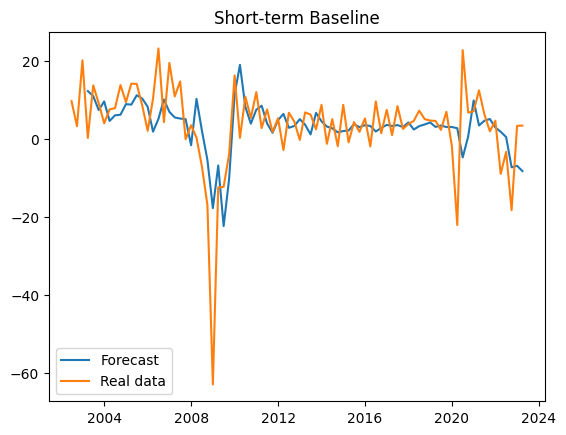

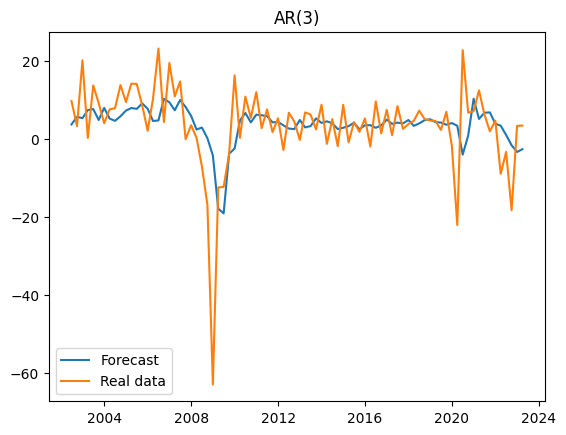

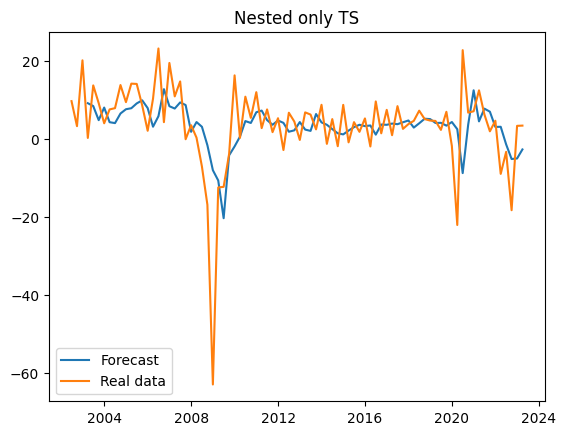

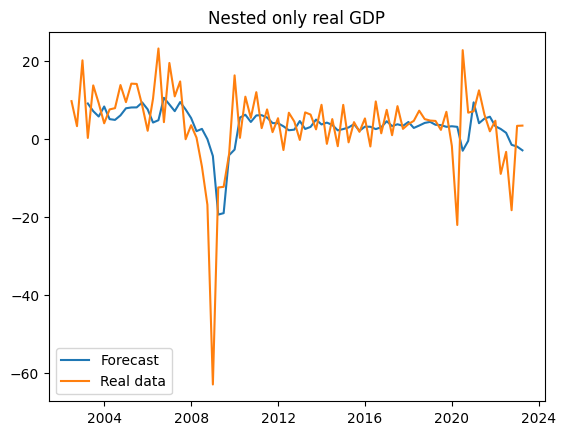

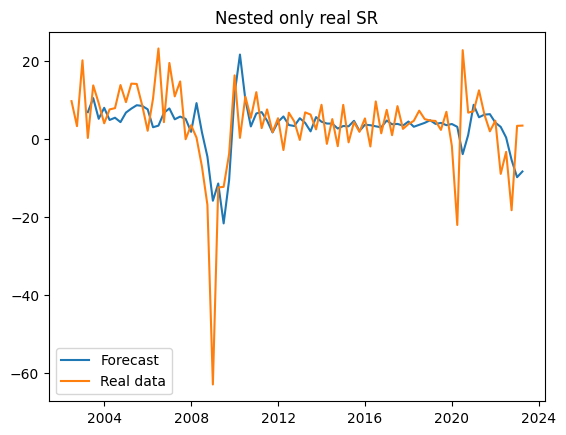

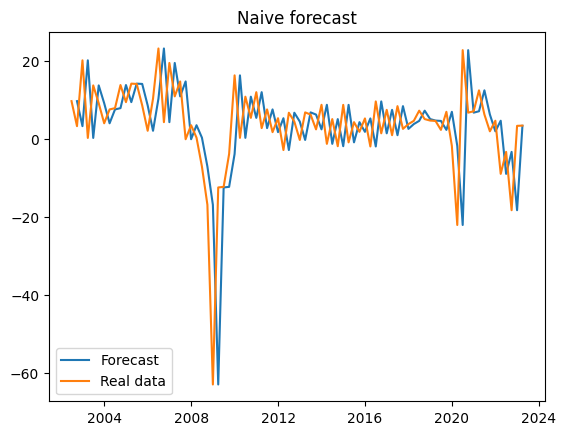

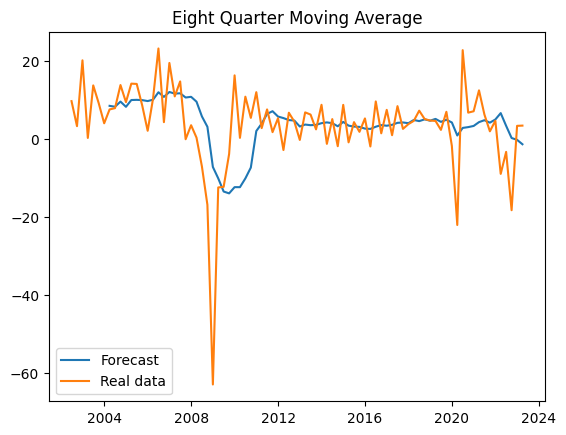

In [34]:
# get all forecast eval stats for short-term models:

st_model_names = [
    'Short-term Baseline', 
    'AR(3)', 
    'Nested only TS', 
    'Nested only real GDP', 
    'Nested only real SR', 
    'Naive forecast', 
    'Eight Quarter Moving Average'
]

st_IS_forecasts = {}
st_IS_forecast_eval_stats = {}
lt_IS_forecasts = {}
lt_IS_forecast_eval_stats = {}

for name, model in zip(st_model_names[:5], st_models):
    st_IS_forecasts[name] = get_IS_pred(model)
st_IS_forecasts['Naive forecast'] = naive_forecast_st
st_IS_forecasts['Eight Quarter Moving Average'] = ma8_st_forecast

for name, forecast in st_IS_forecasts.items():
    st_IS_forecast_eval_stats[name] = compute_evaluation_statistics(transformed_data['st_g'], forecast)
    print(f"{name}: {st_IS_forecast_eval_stats[name]}")

for name, forecast in st_IS_forecasts.items():
    plt.figure()
    plt.plot(forecast, label='Forecast')
    plt.plot(transformed_data['st_g'], label='Real data')
    plt.title(name)
    plt.legend()
    plt.show()

Long-term Baseline: (6.424274458954563, 2.534615248702367, 1.4877353517880099, 6.451891997491357)
AR(3): (13.317214385430987, 3.649275871379278, 2.1888829888257373, 2.479971302953411)
Nested only TS: (10.449899279054836, 3.232630396295691, 2.0423908124537635, 4.730375838575296)
Nested only real GDP: (6.4488832161519865, 2.5394651437166815, 1.5119908921242824, 6.4511253843554925)
Nested only real SR: (13.19090743222956, 3.6319288858992764, 2.1679434432437077, 2.316610587488762)
Naive forecast: (21.17896495015971, 4.602060945941472, 3.0144358381587564, 6.996535255864354)
Eight Quarter Moving Average: (15.216893711155878, 3.9008837090018305, 2.411565285810977, 1.7924163970309537)


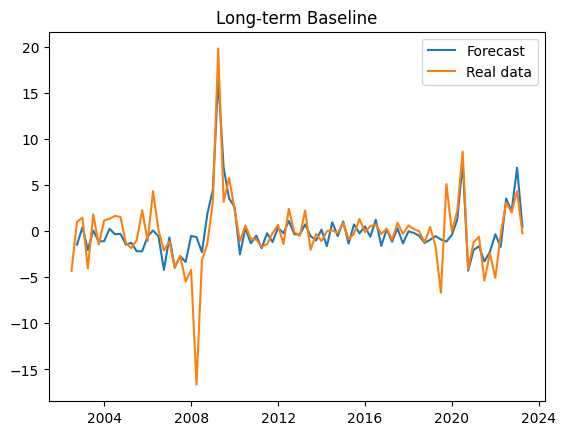

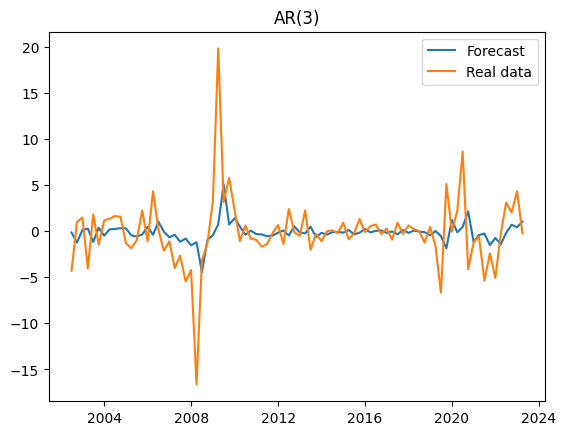

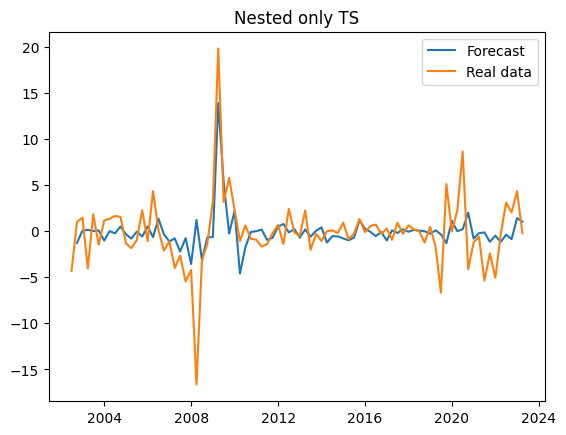

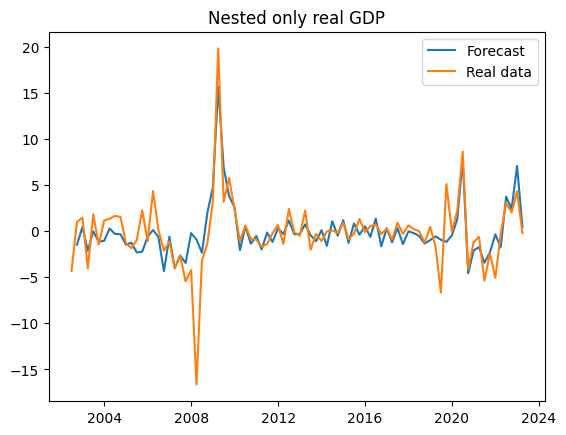

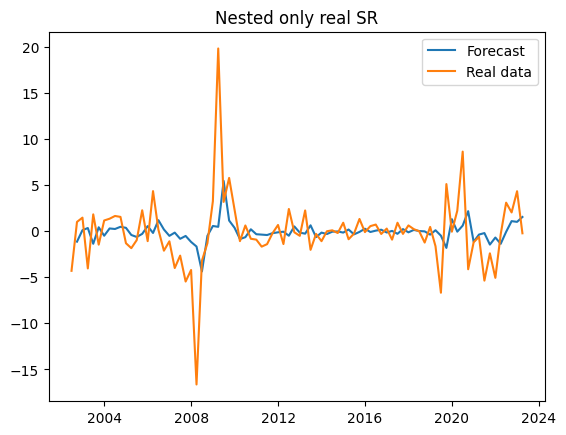

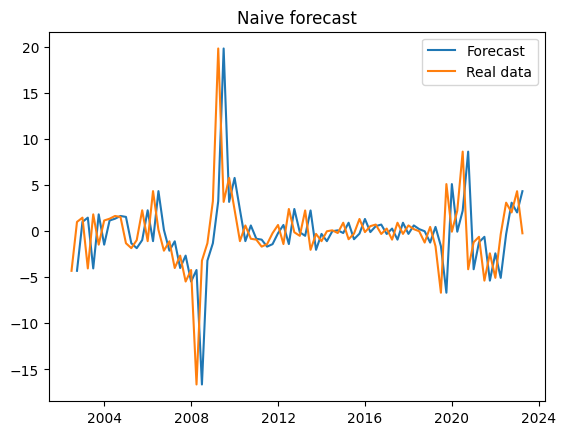

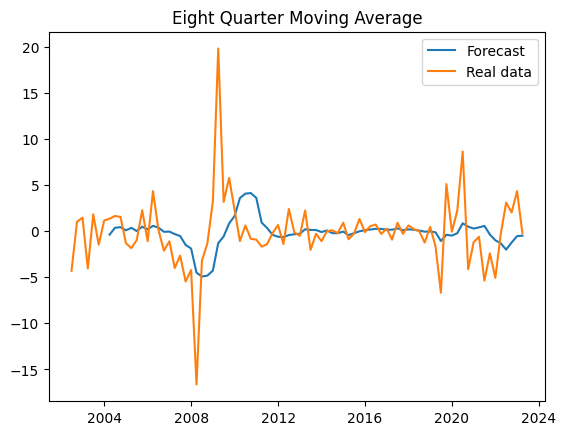

In [35]:
# Define the model names for long-term growth
lt_model_names = [
    'Long-term Baseline', 
    'AR(3)', 
    'Nested only TS', 
    'Nested only real GDP', 
    'Nested only real SR', 
    'Naive forecast', 
    'Eight Quarter Moving Average'
]

# Initialize dictionaries to store forecasts and evaluation statistics
lt_IS_forecasts = {}
lt_IS_forecast_eval_stats = {}

# Generate in-sample forecasts for long-term models
for name, model in zip(lt_model_names[:5], lt_models):
    lt_IS_forecasts[name] = get_IS_pred(model)
lt_IS_forecasts['Naive forecast'] = naive_forecast_lt
lt_IS_forecasts['Eight Quarter Moving Average'] = ma8_lt_forecast

# Compute evaluation statistics for each long-term forecast
for name, forecast in lt_IS_forecasts.items():
    lt_IS_forecast_eval_stats[name] = compute_evaluation_statistics(transformed_data['d_lt_g'], forecast)
    print(f"{name}: {lt_IS_forecast_eval_stats[name]}")

# Plot the forecasts and real data for each model
for name, forecast in lt_IS_forecasts.items():
    plt.figure()
    plt.plot(forecast, label='Forecast')
    plt.plot(transformed_data['d_lt_g'], label='Real data')
    plt.title(name)
    plt.legend()
    plt.show()


OOS Prediction

In [36]:
def forecast_function_OOS_OLS(X_cols, Y_col, y_train, y_test):
    Y = y_train[Y_col]
    X = sm.add_constant(y_train[X_cols])
    warnings.filterwarnings("ignore")
    model = sm.OLS(Y, X)
    model_results = model.fit(cov_type='HAC',cov_kwds={'maxlags':12})

    X_pred = y_test[X_cols]
    ones_column = pd.DataFrame({'const': 1}, index=X_pred.index)
    X_pred = pd.concat([ones_column, X_pred], axis=1)

    # (b) make OOS forecast
    fcast_results = model_results.get_prediction(X_pred)
    fcast_full = fcast_results.summary_frame()

    # (c) select and rename relevant columns from the forecast results
    fcast_full = fcast_full[['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper']]
    fcast_full.columns = ['forec','se(forec)', 'lower CI', 'upper CI']

    y_observed = y_test[Y_col].iloc[0]

    time_index = pd.date_range(start=y_test.index[0], periods=1)
    OOS_summary = pd.DataFrame({'observed': y_observed, 
                        'forecast': fcast_full['forec'], 
                        'CI_low': fcast_full['lower CI'], 
                        'CI_high': fcast_full['upper CI']}, 
                        index=time_index)
    OOS_summary.index.name = 'Time'
    OOS_summary['forec_error'] = OOS_summary['observed'] - OOS_summary['forecast']

    return OOS_summary

def get_OOS_sumamry(data, X_cols, Y_col):
    OOS_start_date = "2004-01-01"                  
    test_set_OOS = data[data.index >= pd.to_datetime(OOS_start_date, format='%Y-%m-%d')]
    oos_window = len(test_set_OOS)

    OOS_summary_all = pd.DataFrame()

    for iter in range(1,oos_window+1):
        # (i) rolling window
        train_set_i = data.iloc[0:len(data)-oos_window-1+iter]
        test_set_i = data.iloc[[-oos_window-1+iter]]

        OOS_summary = forecast_function_OOS_OLS(X_cols, Y_col, train_set_i, test_set_i)
        OOS_summary_all = pd.concat([OOS_summary_all, OOS_summary])

    # clean the OOS results

    OOS_summary_all = OOS_summary_all.drop_duplicates()
    OOS_summary_all = OOS_summary_all.sort_index()
    
    return OOS_summary_all

In [37]:
print(naive_forecast_st)

2002-09-30     9.774386
2002-12-31     3.353189
2003-03-31    20.247290
2003-06-30     0.329072
2003-09-30    13.815077
                ...    
2022-03-31     4.745078
2022-06-30    -8.902659
2022-09-30    -3.254054
2022-12-31   -18.223853
2023-03-31     3.431870
Freq: Q-DEC, Name: st_g, Length: 83, dtype: float64


(301.62893681816155, 17.367467772192974, 10.213368072780199, 55.77445671132996)
(259.80277835053533, 16.118398752684318, 8.875506762606243, 38.18261376076752)
(245.66322577107627, 15.673647494156434, 8.934789104199332, 47.28946344650372)
(192.0856602653027, 13.859497114444762, 8.383622124965568, 39.96958145499653)
(226.3257209421497, 15.044125795211555, 8.417908366805486, 36.61558280218009)
(158.26813141581945, 12.580466263848072, 8.682880136236365, 47.859151832344736)
(106.49505699238298, 10.319644227994635, 6.212160809316163, 36.6988011053165)


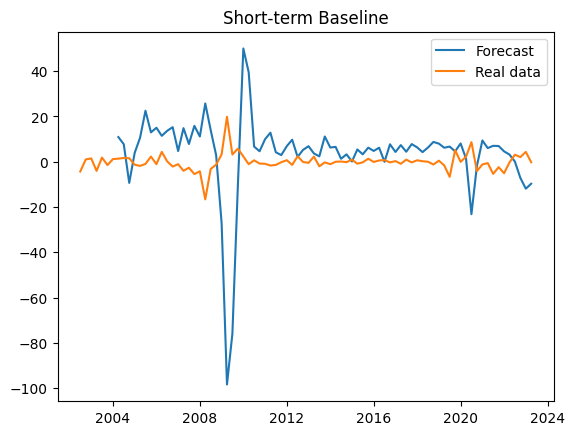

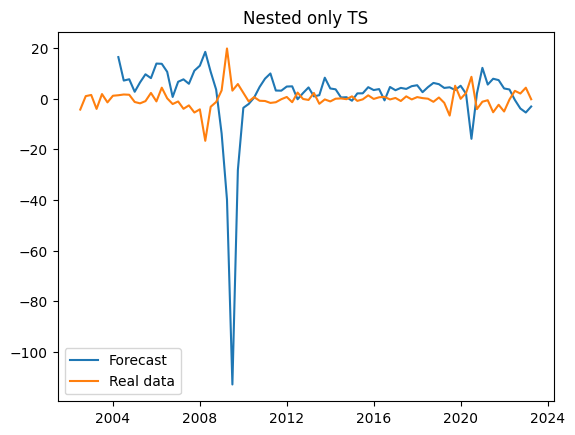

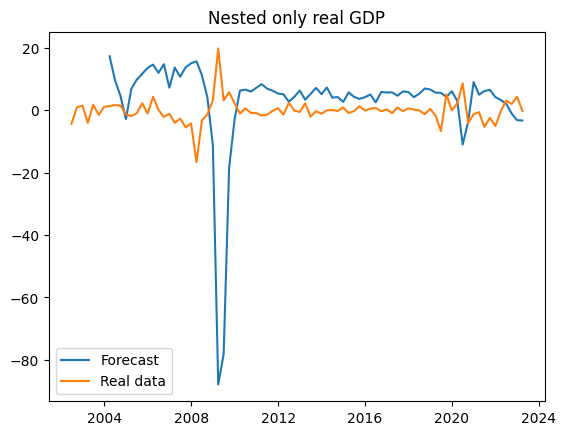

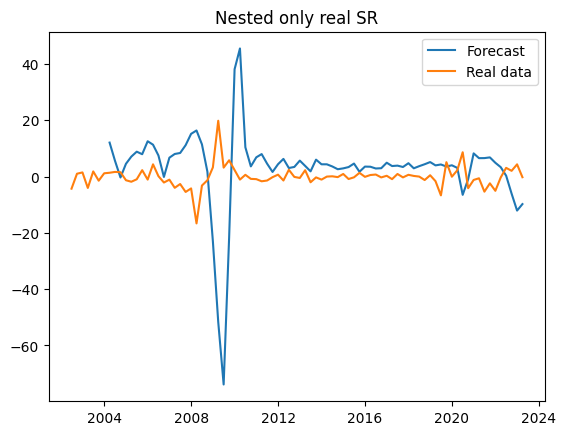

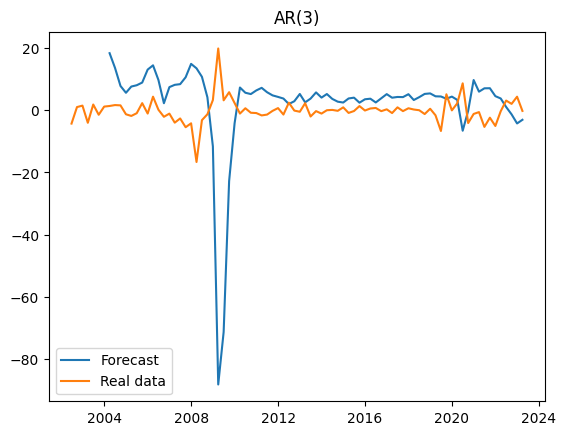

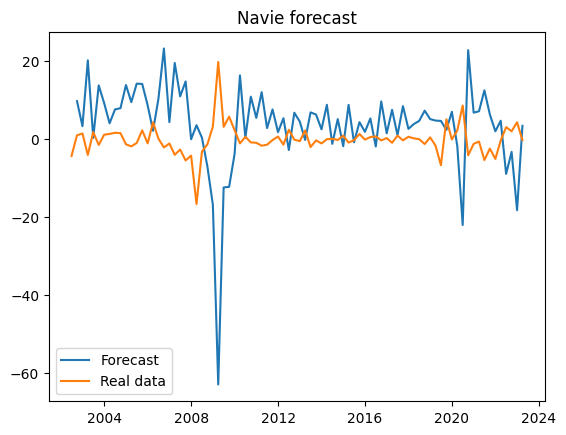

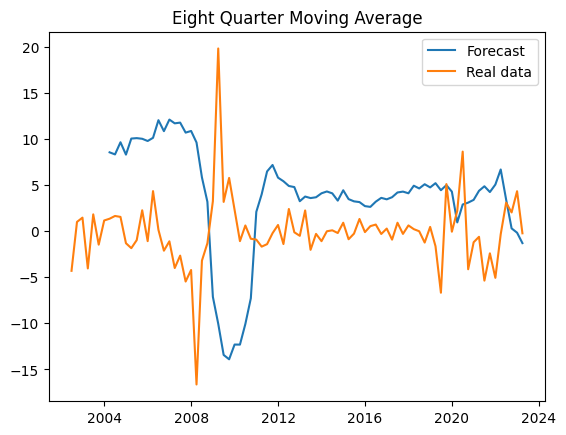

In [41]:
# get all forecast eval stats for short-term models:

st_OOS_forecasts = {
    'Short-term Baseline': get_OOS_sumamry(transformed_data, ['st_g.shift(1)', 'st_g.shift(2)', 'st_g.shift(3)', 'd_TS', 'd_real_SR', 'd_real_GDP'], 'st_g')['forecast'],
    'Nested only TS': get_OOS_sumamry(transformed_data, ['st_g.shift(1)', 'st_g.shift(2)', 'st_g.shift(3)', 'd_TS'], 'st_g')['forecast'],
    'Nested only real GDP': get_OOS_sumamry(transformed_data, ['st_g.shift(1)', 'st_g.shift(2)', 'st_g.shift(3)', 'd_real_GDP'], 'st_g')['forecast'],
    'Nested only real SR': get_OOS_sumamry(transformed_data, ['st_g.shift(1)', 'st_g.shift(2)', 'st_g.shift(3)', 'd_real_SR'], 'st_g')['forecast'],
    'AR(3)': get_OOS_sumamry(transformed_data, ['st_g.shift(1)', 'st_g.shift(2)', 'st_g.shift(3)'], 'st_g')['forecast'],
    'Navie forecast': naive_forecast_st,
    'Eight Quarter Moving Average': ma8_st_forecast
}

st_OOS_forecast_eval_stats = []

for name, forecast in st_OOS_forecasts.items():
    st_OOS_forecast_eval_stats.append(compute_evaluation_statistics(transformed_data['st_g'], forecast))
    print(st_OOS_forecast_eval_stats[-1])

for name, forecast in st_OOS_forecasts.items():
    plt.figure()
    plt.plot(forecast, label='Forecast')
    plt.plot(transformed_data['d_lt_g'], label='Real data')
    plt.title(name)
    plt.legend()
    plt.show()

(24.088821833445376, 4.908036453964597, 2.4172569080565167, 7.734830403295545)
(38.17309048233613, 6.178437543775621, 2.916849451234303, 5.908151825864869)
(9.213907984768877, 3.0354419751938724, 1.8319187405536346, 7.786986891156726)
(18.741229654938117, 4.329114188253541, 2.5283171069606225, 2.970889004468868)
(15.968130151310495, 3.9960142831714824, 2.442778801557294, 3.1472496515201365)
(21.17896495015971, 4.602060945941472, 3.0144358381587564, 6.996535255864354)
(15.216893711155878, 3.9008837090018305, 2.411565285810977, 1.7924163970309537)


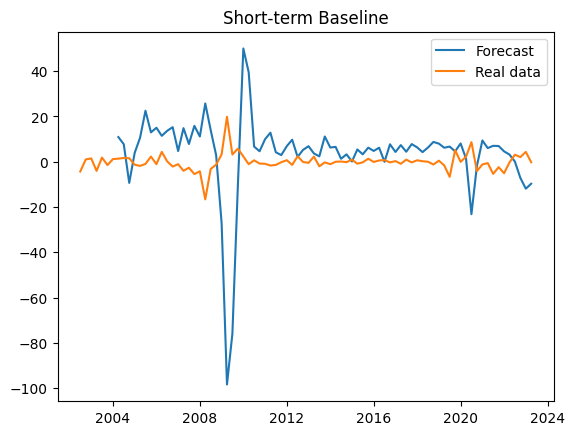

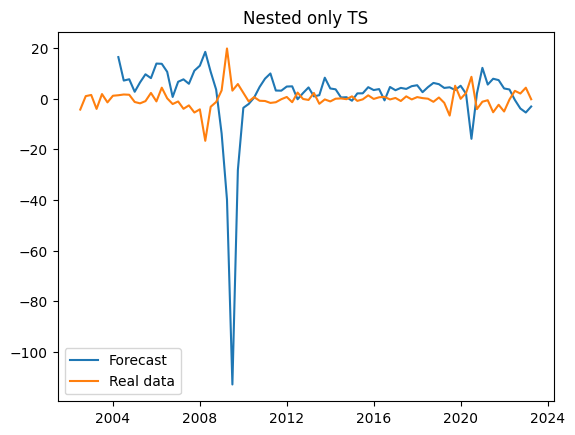

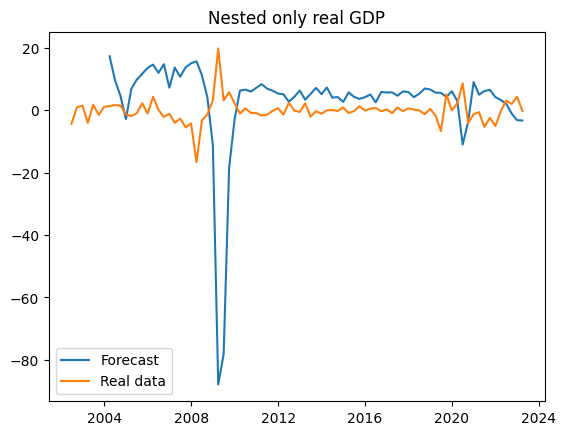

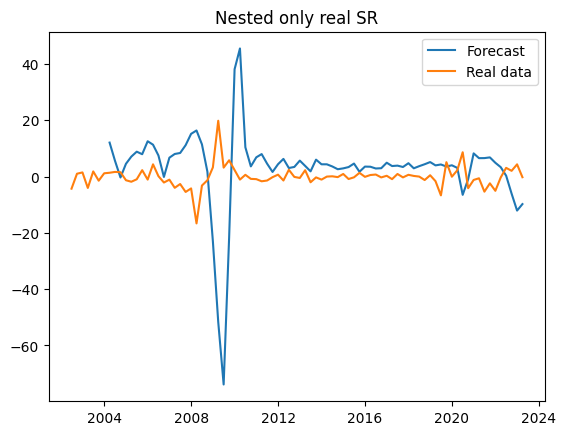

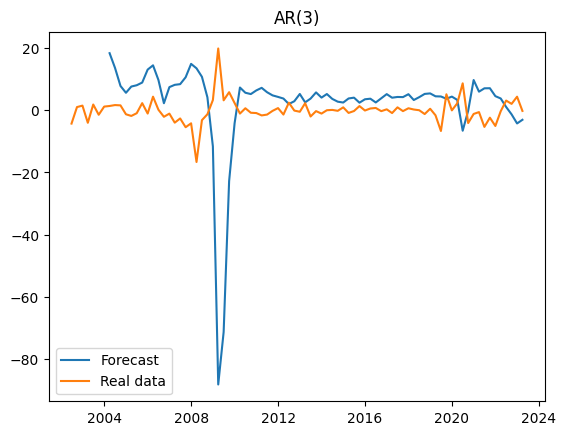

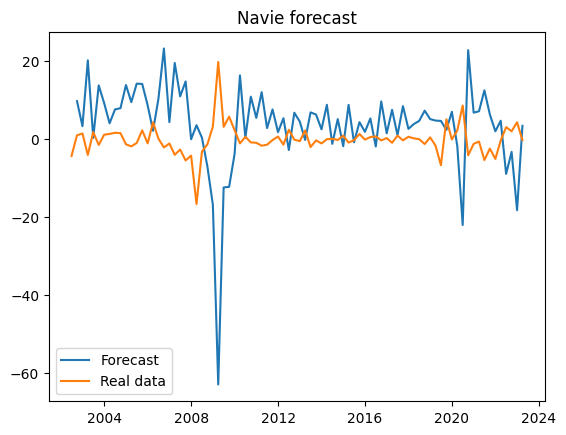

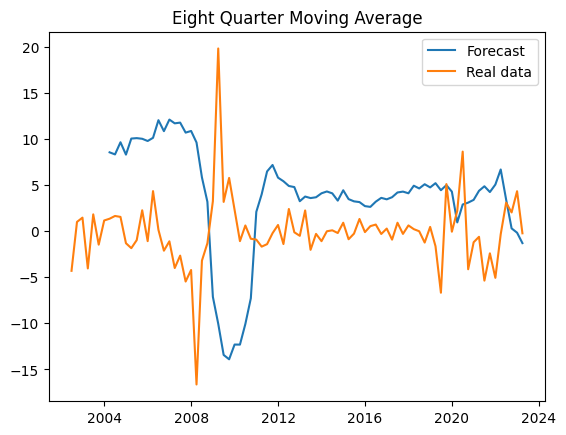

In [42]:
lt_OOS_forecasts = {
    'Long-term Baseline': get_OOS_sumamry(transformed_data, ['d_lt_g.shift(1)', 'd_TS', 'd_real_SR', 'd_real_GDP'], 'd_lt_g')['forecast'],
    'Nested only TS': get_OOS_sumamry(transformed_data, ['d_lt_g.shift(1)', 'd_TS'], 'd_lt_g')['forecast'],
    'Nested only real GDP': get_OOS_sumamry(transformed_data, ['d_lt_g.shift(1)', 'd_real_GDP'], 'd_lt_g')['forecast'],
    'Nested only real SR': get_OOS_sumamry(transformed_data, ['d_lt_g.shift(1)', 'd_real_SR'], 'd_lt_g')['forecast'],
    'AR(3)': get_OOS_sumamry(transformed_data, ['d_lt_g.shift(1)'], 'd_lt_g')['forecast'],
    'Naive forecast': naive_forecast_lt,
    'Eight Quarter Moving Average': ma8_lt_forecast
}

lt_OOS_forecast_eval_stats = []

for name, forecast in lt_OOS_forecasts.items():
    lt_OOS_forecast_eval_stats.append(compute_evaluation_statistics(transformed_data['d_lt_g'], forecast))
    print(lt_OOS_forecast_eval_stats[-1])

for name, forecast in st_OOS_forecasts.items():
    plt.figure()
    plt.plot(forecast, label='Forecast')
    plt.plot(transformed_data['d_lt_g'], label='Real data')
    plt.title(name)
    plt.legend()
    plt.show()


11. Model Evaluation

In [60]:
def DM_HLN_test(forec1, forec2, verbose=False):

    h=1
    e1 = forec1
    e2 = forec2
    T = e1.shape[0]
    d = e1**2-e2**2
    dm = d.mean().values[0]   

    gamma_0 = (1/T)*((d-dm)**2).sum().values[0]
    var_d = (1/T)*gamma_0
    std_d = np.sqrt(var_d)

    DM_stat = dm/std_d

    DM_pval1 = 2*(1-norm.cdf(abs(DM_stat)))  # for H1: forec_error_1 != forec_error_2
    DM_pval2 = 1-norm.cdf(DM_stat)           # for H1: forec_error_1 > forec_error_2, forec_2 is better


    DM_HLN_stat = DM_stat*np.sqrt((T+1-2*h+h*(h-1))/T)

    DM_HLN_pval1 = 2*(1-stats.t.cdf(abs(DM_HLN_stat), T-1))   # for H1: forec_error_1 != forec_error_2
    DM_HLN_pval2 = 1-stats.t.cdf(DM_HLN_stat, T-1)            # for H1: forec_error_1 > forec_error_2, forec_2 is better


    if verbose:
        print('----------------------------------------------------------------------\n')
        print('Diebold-Mariano (DM) test with HLN correction for h=1\n')
        print('H0: MSE(1) = MSE(2) ---> equal predictive accuracy (forec_error_1 = forec_error_2)')
        print('H1: MSE(1) != MSE(2) ---> unequal predictive accuracy')
        print(f'\nDM test stat: {DM_stat:.4f}')
        print(f'DM p-value: {DM_pval1:.4f}')
        print(f'DM-HLN test stat: {DM_HLN_stat:.4f}')
        print(f'DM-HLN p-value: {DM_HLN_pval1:.4f}')
        print('----------------------------------------------------------------------\n')

        print('Diebold-Mariano (DM) test with HLN correction for h=1\n')
        print('H0: MSE(1) = MSE(2) ---> equal predictive accuracy (forec_error_1 = forec_error_2)')
        print('H1: MSE(1) > MSE(2) ---> unequal predictive accuracy (forec 2 is better)')
        print(f'\nDM test stat: {DM_stat:.4f}')
        print(f'DM p-value: {DM_pval2:.4f}')
        print(f'DM-HLN test stat: {DM_HLN_stat:.4f}')
        print(f'DM-HLN p-value: {DM_HLN_pval2:.4f}')
        print('----------------------------------------------------------------------\n')

    return {
        'DM_stat': DM_stat, 'DM_pval1': DM_pval1, 'DM_HLN_stat': DM_HLN_stat, 'DM_HLN_pval1': DM_HLN_pval1, 'DM_pval2': DM_pval2, 'DM_HLN_pval2': DM_HLN_pval2
    }


def newey_west(Z, nlags):
    """
    Returns the Newey-West estimator of the asymptotic variance matrix.
    
    Parameters:
    Z : array_like, shape (n, k)
        A nxk matrix with rows the vector zt'.
    nlags : int
        The number of lags.
        
    Returns:
    omegahat : array_like, shape (k, k)
        The Newey-West estimator of the covariance matrix.
    """
    n, k = Z.shape

    # De-mean the variables
    Z = Z - np.mean(Z, axis=0)

    samplevar = np.dot(Z.T, Z) / n  # Sample variance
    omegahat = samplevar.copy()
    
    if nlags > 0:
        # Sample autocovariances
        for ii in range(1, nlags + 1):
            Zlag = np.vstack([np.zeros((ii, k)), Z[:-ii]])
            gamma = (np.dot(Z.T, Zlag) + np.dot(Zlag.T, Z)) / n
            weights = 1 - (ii / (nlags + 1))
            omegahat += weights * gamma

    return omegahat


def EPA_test(forec1, forec2, h, choice, verbose=False):

    tau=h
    loss1 = forec1**2
    loss2 = forec2**2
    alpha = 0.05
    lossdiff1 = loss1 - loss2  # Loss differential
    TT = len(lossdiff1)

    if choice == 1:
        instruments = np.ones((TT, 1))
        lossdiff = lossdiff1
        T = TT
    else:
        instruments = np.column_stack([np.ones(TT - tau), lossdiff1[:TT - tau]])
        lossdiff = lossdiff1[tau:]
        T = TT - tau

    reg = np.zeros_like(instruments)
    for jj in range(instruments.shape[1]):
        reg[:, jj] = instruments[:, jj] * lossdiff

    if tau == 1:
        res = np.linalg.lstsq(reg, np.ones(T), rcond=None)[0]
        err = np.ones(T) - reg @ res
        r2 = 1 - np.mean(err**2)
        teststat = T * r2
        q = reg.shape[1]
        critval = chi2.ppf(1 - alpha, q)
        pval = 1 - chi2.cdf(abs(teststat), q)
    else:
        zbar = np.mean(reg, axis=0)
        nlags = tau - 1
        omega = newey_west(reg, nlags)
        teststat = T * zbar.T @ np.linalg.inv(omega) @ zbar
        q = reg.shape[1]
        critval = chi2.ppf(1 - alpha, q)
        pval = 1 - chi2.cdf(abs(teststat), q)

    av_diff_loss = np.mean(loss1 - loss2)
    gwsign = np.sign(av_diff_loss)

    if av_diff_loss < 0:
        sign1 = '(-)'
    elif av_diff_loss > 0:
        sign1 = '(+)'
    else:
        sign1 = '(0)'

    if verbose:
        print('---------------------------------------------------------------------------\n')
        print('Giacomini and White (2006) EPA test\n')
        print('H0: equal predictive accuracy (forec_error_1 = forec_error_2)')
        print('H1: unequal predictive accuracy')
        print('The sign of the test-statistics indicates which forecast performs better:')
        print('  (1) EPA test stat > 0  ===> model 2 is better (produces lower forecast errors)')
        print('  (2) EPA test stat < 0  ===> model 1 is better (produces lower forecast errors)')
        print(f'Forecast horizon: {tau}')
        #print(f'Alpha: {alpha:.2f}')

        if choice == 1:
            print('-----------------------------------')
            print('Choice: Unconditional EPA Test\n')
        else:
            print('-----------------------------------')
            print('Choice: Conditional EPA Test\n')
        
        print(f'EPA test stat: {teststat:.4f} {sign1}')
        print(f'critical value: {critval:.4f}')
        print(f'p-value: {pval:.4f}')
        print('                                 ')
        print('---------------------------------------------------------------------------\n')

    return {
        teststat: teststat, 'critval': critval, 'pval': pval
    }


def test(baseline_name, model_forecasts, verbose=False):
    comparison_results = {}
    baseline_forecast = model_forecasts[baseline_name]

    for model_name, model_forecast in model_forecasts.items():
        if model_name != baseline_name:
            print(f"DM_HNL test {model_name} and {baseline_name}:")
            dm_results = DM_HLN_test(pd.DataFrame(baseline_forecast), pd.DataFrame(model_forecast), verbose=True)
            epa_unconditional_results = EPA_test(baseline_forecast, model_forecast, h=1, choice=1, verbose=True)
            epa_conditional_results = EPA_test(baseline_forecast, model_forecast, h=1, choice=2, verbose=True)

            comparison_results[model_name] = {
                'DM_HLN': dm_results,
                'EPA_Unconditional': epa_unconditional_results,
                'EPA_Conditional': epa_conditional_results
            }

    return comparison_results

In [83]:
st_forecast_errors = {
    'Short-term Baseline': get_OOS_sumamry(transformed_data, ['st_g.shift(1)', 'd_TS', 'd_real_SR', 'd_real_GDP'], 'st_g')['forec_error'],
    'Nested only TS': get_OOS_sumamry(transformed_data, ['st_g.shift(1)', 'd_TS'], 'st_g')['forec_error'],
    'Nested only real GDP': get_OOS_sumamry(transformed_data, ['st_g.shift(1)', 'd_real_GDP'], 'st_g')['forec_error'],
    'Nested only real SR': get_OOS_sumamry(transformed_data, ['st_g.shift(1)', 'd_real_SR'], 'st_g')['forec_error'],
    'AR(3)': get_OOS_sumamry(transformed_data, ['st_g.shift(1)'], 'st_g')['forec_error'],
}

baseline_name = 'Short-term Baseline'
model_forecasts = st_forecast_errors

test(baseline_name, model_forecasts, verbose=True)

DM_HNL test Nested only TS and Short-term Baseline:
----------------------------------------------------------------------

Diebold-Mariano (DM) test with HLN correction for h=1

H0: MSE(1) = MSE(2) ---> equal predictive accuracy (forec_error_1 = forec_error_2)
H1: MSE(1) != MSE(2) ---> unequal predictive accuracy

DM test stat: 1.0655
DM p-value: 0.2866
DM-HLN test stat: 1.0586
DM-HLN p-value: 0.2931
----------------------------------------------------------------------

Diebold-Mariano (DM) test with HLN correction for h=1

H0: MSE(1) = MSE(2) ---> equal predictive accuracy (forec_error_1 = forec_error_2)
H1: MSE(1) > MSE(2) ---> unequal predictive accuracy (forec 2 is better)

DM test stat: 1.0655
DM p-value: 0.1433
DM-HLN test stat: 1.0586
DM-HLN p-value: 0.1466
----------------------------------------------------------------------

---------------------------------------------------------------------------

Giacomini and White (2006) EPA test

H0: equal predictive accuracy (forec_

{'Nested only TS': {'DM_HLN': {'DM_stat': 1.0655406170980335,
   'DM_pval1': 0.2866313553686708,
   'DM_HLN_stat': 1.0585989105190303,
   'DM_HLN_pval1': 0.2931355112050418,
   'DM_pval2': 0.1433156776843354,
   'DM_HLN_pval2': 0.1465677556025209},
  'EPA_Unconditional': {1.1188787676943286: 1.1188787676943286,
   'critval': 3.841458820694124,
   'pval': 0.2901600123919289},
  'EPA_Conditional': {1.1368684050674291: 1.1368684050674291,
   'critval': 5.991464547107979,
   'pval': 0.5664116306160436}},
 'Nested only real GDP': {'DM_HLN': {'DM_stat': 1.1453885002683697,
   'DM_pval1': 0.25204825986637913,
   'DM_HLN_stat': 1.1379266065026663,
   'DM_HLN_pval1': 0.2587257642646743,
   'DM_pval2': 0.12602412993318957,
   'DM_HLN_pval2': 0.12936288213233715},
  'EPA_Unconditional': {1.2899370563312584: 1.2899370563312584,
   'critval': 3.841458820694124,
   'pval': 0.2560595506971667},
  'EPA_Conditional': {1.3543527415924395: 1.3543527415924395,
   'critval': 5.991464547107979,
   'pval': 0

In [84]:
lt_forecast_errors = {
    'Long-term Baseline': get_OOS_sumamry(transformed_data, ['d_lt_g.shift(1)', 'd_TS', 'd_real_SR', 'd_real_GDP'], 'd_lt_g')['forec_error'],
    'Nested only TS': get_OOS_sumamry(transformed_data, ['d_lt_g.shift(1)', 'd_TS'], 'd_lt_g')['forec_error'],
    'Nested only real GDP': get_OOS_sumamry(transformed_data, ['d_lt_g.shift(1)', 'd_real_GDP'], 'd_lt_g')['forec_error'],
    'Nested only real SR': get_OOS_sumamry(transformed_data, ['d_lt_g.shift(1)', 'd_real_SR'], 'd_lt_g')['forec_error'],
    'AR(3)': get_OOS_sumamry(transformed_data, ['d_lt_g.shift(1)'], 'd_lt_g')['forec_error'],
}

baseline_name = 'Long-term Baseline'
model_forecasts = lt_forecast_errors

test(baseline_name, model_forecasts, verbose=True)

DM_HNL test Nested only TS and Long-term Baseline:
----------------------------------------------------------------------

Diebold-Mariano (DM) test with HLN correction for h=1

H0: MSE(1) = MSE(2) ---> equal predictive accuracy (forec_error_1 = forec_error_2)
H1: MSE(1) != MSE(2) ---> unequal predictive accuracy

DM test stat: -1.0950
DM p-value: 0.2735
DM-HLN test stat: -1.0879
DM-HLN p-value: 0.2801
----------------------------------------------------------------------

Diebold-Mariano (DM) test with HLN correction for h=1

H0: MSE(1) = MSE(2) ---> equal predictive accuracy (forec_error_1 = forec_error_2)
H1: MSE(1) > MSE(2) ---> unequal predictive accuracy (forec 2 is better)

DM test stat: -1.0950
DM p-value: 0.8633
DM-HLN test stat: -1.0879
DM-HLN p-value: 0.8600
----------------------------------------------------------------------

---------------------------------------------------------------------------

Giacomini and White (2006) EPA test

H0: equal predictive accuracy (for

{'Nested only TS': {'DM_HLN': {'DM_stat': -1.0950431601420092,
   'DM_pval1': 0.2734977283903781,
   'DM_HLN_stat': -1.0879092525395448,
   'DM_HLN_pval1': 0.2800732324620854,
   'DM_pval2': 0.8632511358048109,
   'DM_HLN_pval2': 0.8599633837689573},
  'EPA_Unconditional': {1.1807320057040878: 1.1807320057040878,
   'critval': 3.841458820694124,
   'pval': 0.2772070241289082},
  'EPA_Conditional': {2.463708089987524: 2.463708089987524,
   'critval': 5.991464547107979,
   'pval': 0.2917511561555246}},
 'Nested only real GDP': {'DM_HLN': {'DM_stat': 1.2458722532424484,
   'DM_pval1': 0.21281129811014599,
   'DM_HLN_stat': 1.2377557352250645,
   'DM_HLN_pval1': 0.21961691636306657,
   'DM_pval2': 0.10640564905507299,
   'DM_HLN_pval2': 0.10980845818153329},
  'EPA_Unconditional': {1.5215261220027094: 1.5215261220027094,
   'critval': 3.841458820694124,
   'pval': 0.21738869150741214},
  'EPA_Conditional': {3.2250037090186074: 3.2250037090186074,
   'critval': 5.991464547107979,
   'pval':